In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import cv2
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
cudnn.benchmark = True
from scipy.stats import kstest

plt.ion()


In [3]:
data_dir_train = '/kaggle/input/iasa-champ-24-ui-element-sketch-classification/ui_icons_dataset/ui_icons_dataset/train'
data_dir_test = '/kaggle/input/iasa-champ-24-ui-element-sketch-classification/ui_icons_dataset/ui_icons_dataset/test'
df = pd.read_csv('/kaggle/input/iasa-champ-24-ui-element-sketch-classification/predictions_example.csv')
df

,ID,Target
0,079c715e-0387-4fa2-abc0-5cc7a81120f6.jpg,text_field
1,a7b15b95-c998-4c3a-85c9-9eae9143c894.jpg,card
2,69123d68-e442-4cae-8f86-9c3f4c985760.jpg,data_table
3,c61abe0a-54bc-4cfd-b5bd-ccfff2e0d535.jpg,switch_enabled
4,ec5c04b8-d75f-4414-821f-6e845a6bfad3.jpg,chip
...,...,...
5138,deecda16-bb84-4164-8857-8c1ddfca5e61.jpg,card
5139,da48f7f4-bec7-4ad1-bebf-1c7a7de667f4.jpg,label
5140,e82902f5-5b77-4ed9-91a4-d20300aef23f.jpg,dropdown_menu
5141,e9a52c92-865a-45aa-a6ba-ea427b462f48.jpg,text_field


This code block extracts unique class labels from the 'Target' column of the DataFrame `df`.
1. A copy of the 'Target' column is created and stored in the variable `targets`.
2. Unique values are extracted from `targets` and stored in the array `all_targets`.
3. The array of unique class labels and the count of unique class labels are printed.

In [24]:
targets=  df['Target'].copy()
all_targets = targets.unique()
print(all_targets)
print(len(all_targets))

['text_field' 'card' 'data_table' 'switch_enabled' 'chip' 'image' 'menu'
 'text_area' 'label' 'switch_disabled' 'radio_button_unchecked' 'slider'
 'checkbox_checked' 'floating_action_button' 'grid_list' 'dropdown_menu'
 'alert' 'radio_button_checked' 'tooltip' 'button' 'checkbox_unchecked']
21


This code iterates over each target name in all_targets, checks if a corresponding folder exists in the data_dir_train directory, counts the number of files in each folder, and populates a dictionary with target names as keys and file counts as values.

In [26]:
dictionary = {}
for target_name in all_targets:
  folder_path = os.path.join(data_dir_train, target_name)
  if os.path.exists(folder_path) and os.path.isdir(folder_path):
    num_files = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
  dictionary[target_name] = num_files
print(dictionary)

{'text_field': 831, 'card': 781, 'data_table': 718, 'switch_enabled': 695, 'chip': 678, 'image': 876, 'menu': 720, 'text_area': 639, 'label': 790, 'switch_disabled': 678, 'radio_button_unchecked': 747, 'slider': 679, 'checkbox_checked': 830, 'floating_action_button': 689, 'grid_list': 655, 'dropdown_menu': 642, 'alert': 690, 'radio_button_checked': 681, 'tooltip': 635, 'button': 920, 'checkbox_unchecked': 825}


This function Kolmogorov_Smirnov_test performs the Kolmogorov-Smirnov test on the distribution of file counts across different target classes. It calculates the test statistic and p-value using the kstest function from the scipy.stats module, compares the p-value to a significance level (alpha), and returns False if the null hypothesis is rejected (indicating that the distributions are significantly different) and True otherwise. Finally, it prints the result of the test.

In [29]:
def Kolmogorov_Smirnov_test(targets, dictionary):
  counts = list(dictionary.values())
  ks_statistic, p_value = kstest(counts, 'uniform', args = (min(dictionary.values()), max(dictionary.values())))
  print("Статистика Колмогорова-Смирнова:", ks_statistic)
  print("p-value:", p_value)

  alpha = 0.1
  if p_value < alpha:
    return False
  else:
    return True

res = Kolmogorov_Smirnov_test(targets, dictionary)
print("Result of Kolmogorov-Smirnov test:", res)

Статистика Колмогорова-Смирнова: 0.6917184265010352
p-value: 1.4975165899252134e-10
Result of Kolmogorov-Smirnov test: False


This code block plots a bar chart showing the distribution of samples across different classes. It extracts categories and counts from the dictionary, then uses Matplotlib to create and display the bar chart.

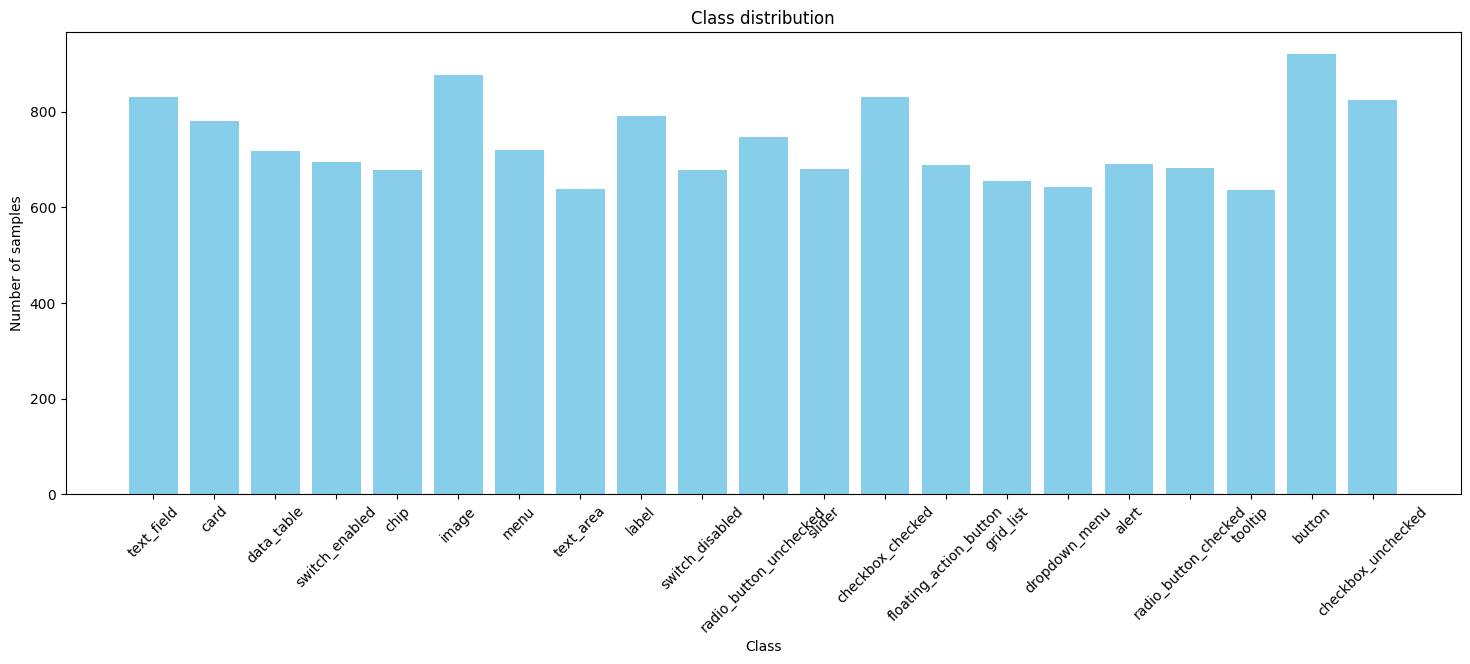

In [30]:
categories = dictionary.keys()
counts = dictionary.values()

plt.figure(figsize = (18, 6))
plt.bar(categories, counts, color = 'skyblue')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of samples')

plt.xticks(rotation = 45)
plt.show()

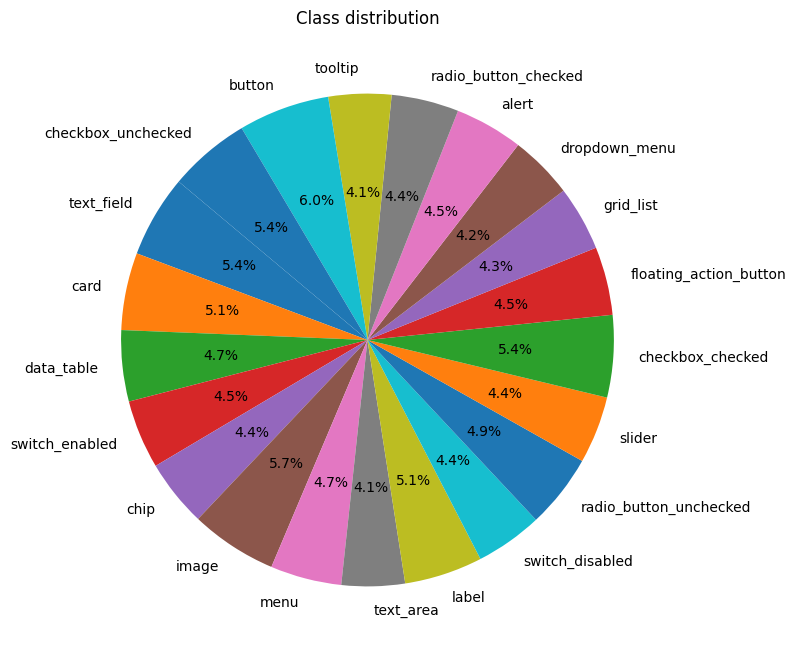

In [31]:
plt.figure(figsize = (8,8))
plt.pie(counts, labels = categories, autopct='%1.1f%%', startangle=140)
plt.title('Class distribution')
plt.show()

In [34]:
random_image_path = '/kaggle/input/iasa-champ-24-ui-element-sketch-classification/ui_icons_dataset/ui_icons_dataset/train/alert/002fc7c6-f324-4021-b358-205a5e34ac3b.jpg'
random_image = cv2.imread(random_image_path)
image_size = random_image.shape
print(image_size)

(224, 224, 3)


The ImageFolder class is a custom dataset class inheriting from PyTorch's Dataset class. It's designed to load images from a folder structure organized by class names. The constructor initializes the dataset with parameters such as the root folder containing the class subdirectories, a list of class names, optional data transformations, the total number of classes, and a class encoding dictionary. The __len__ method returns the total number of samples in the dataset, while the __getitem__ method retrieves a sample by index, loading the image, converting it to grayscale, applying transformations, and returning the grayscale image along with its target label as tensors. This class is useful for creating datasets for image classification tasks in PyTorch.

In [5]:
class ImageFolder(Dataset):
    def __init__(self, root_folder, classes_name, transform=None, total_classes=21, class_encoding=None):
        self.transform = transform
        self.data = []
        self.classes_name = classes_name
        self.total_classes = total_classes
        self.class_encoding = class_encoding

        for class_name in self.classes_name:
            image_path = os.path.join(root_folder, class_name)
            for filename in os.listdir(image_path):
                image_path_full = os.path.join(image_path, filename)
                self.data.append((image_path_full, self.class_encoding[class_name]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data, target = self.data[index]
        image = Image.open(data)  # Используем PIL для открытия изображения

        gray_image = image.convert('L')

        if self.transform:
            gray_image = self.transform(gray_image)  # Передаем изображение напрямую аугментациям

        target = torch.tensor(target)

        return gray_image, target

The CustomTestDataset class is a custom dataset class inheriting from PyTorch's Dataset. It's designed for creating a dataset of images for testing purposes. The constructor initializes the dataset with parameters such as the directory containing the images and optional data transformations. The __len__ method returns the total number of images in the dataset, while the __getitem__ method retrieves an image by index, loads it, converts it to grayscale, applies transformations if provided, and returns the grayscale image as a tensor. This class is useful for creating datasets for testing image-related functionalities in PyTorch.

In [6]:
class CustomTestDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)  # Получаем список файлов в каталоге
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]  # Получаем имя изображения
        img_path = os.path.join(self.data_dir, img_name)  # Получаем полный путь к изображению
        image = Image.open(img_path)  # Загружаем изображение

        gray_image = image.convert('L')

        if self.transform:
            gray_image = self.transform(gray_image)

        return gray_image


This code block sets up data loaders for training, validation, and testing. First, it defines transformations for the test dataset, including resizing images to 224x224 pixels, converting them to tensors, and normalizing them. Then, it constructs a dictionary called class_encoding that maps class names to integer labels.

Next, it creates an ImageFolder dataset called full_dataset_to_train for training with the specified root directory, list of class names, and transformations. The class_encoding dictionary is passed to map class names to integer labels.

Additionally, it constructs a CustomTestDataset dataset called test_dataset for testing with the specified root directory and transformations.

The full training dataset is randomly split into training and validation datasets using random_split, with 80% of the data allocated to training and the remaining 20% to validation.

A batch size of 32 is set for data loading.

Finally, data loaders for training, validation, and testing datasets are created using DataLoader. These loaders handle batch loading, shuffling, and multiprocessing, making them efficient for deep learning model training and evaluation.

In [7]:
Simple_Transformer_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

class_encoding = {class_name: i for i, class_name in enumerate(all_targets)}


full_dataset_to_train = ImageFolder(data_dir_train, all_targets, transform = Simple_Transformer_test, class_encoding=class_encoding)
test_dataset = CustomTestDataset(data_dir=data_dir_test, transform=Simple_Transformer_test)

train_dataset, val_dataset = random_split(full_dataset_to_train, [int(0.8*(len(full_dataset_to_train))), len(full_dataset_to_train) - int(0.8*(len(full_dataset_to_train)))])

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers= 4)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers= 4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


This code block defines a set of transformations Simple_Transformer_train for training data, including resizing images to 224x224 pixels, random horizontal flipping, random affine transformations (rotation, translation, and scaling), random horizontal flipping and rotation with specified probabilities, conversion to grayscale, conversion to tensors, and normalization.

It then creates a training dataset full_dataset_to_train_1 using the ImageFolder class with the specified root directory, class names, and transformations. Additionally, a class encoding dictionary is provided to map class names to integer labels.

Finally, a data loader train_loader_1 is created using DataLoader for the training dataset. It handles batch loading, shuffling, and multiprocessing with a batch size of 32 and 4 worker processes. This setup is commonly used in deep learning pipelines for training models on image datasets.

In [8]:
Simple_Transformer_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.RandomApply([transforms.RandomHorizontalFlip()], p=0.5),
    transforms.RandomApply([transforms.RandomRotation(15)], p=0.5),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]) 
])
    
full_dataset_to_train_1 = ImageFolder(data_dir_train, all_targets, transform = Simple_Transformer_train, class_encoding=class_encoding)
train_loader_1 = DataLoader(full_dataset_to_train_1, batch_size = BATCH_SIZE, shuffle = True, num_workers= 4)

This is useful for understanding the dimensions of the batch of data being processed, which helps ensure compatibility with the model architecture during training.

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape) 
print(labels.shape)  

torch.Size([32, 1, 224, 224])
torch.Size([32])


In [10]:
data_iter = iter(train_loader_1)
images, labels = next(data_iter)
print(images.shape)  
print(labels.shape)  

torch.Size([32, 1, 224, 224])
torch.Size([32])


In [11]:
data_iter = iter(test_loader)
images = next(data_iter)
print(images.shape)  

torch.Size([32, 1, 224, 224])


In [12]:
data_iter = iter(val_dataset)
images, labels = next(data_iter)
print(images.shape) 
print(labels.shape)  

torch.Size([1, 224, 224])
torch.Size([])


In [13]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

12319
3080
5143


This code implements the ResNet architecture, a deep neural network commonly used for image classification tasks. The ResNet architecture introduces residual blocks, which help address the problem of vanishing gradients in deep networks by incorporating skip connections or shortcuts.

The block class represents a single residual block within the ResNet architecture. It consists of convolutional layers followed by batch normalization and ReLU activation functions. The forward method defines the forward pass through the block, including the application of residual connections.

The ResNet class defines the overall ResNet architecture, which consists of multiple layers of residual blocks. It includes convolutional, batch normalization, activation, max-pooling, residual, and fully connected layers. The _make_layer method constructs a sequence of residual blocks within each layer of the ResNet architecture.

Additionally, convenience functions ResNet50, ResNet101, and ResNet152 are provided to instantiate ResNet models with different numbers of layers, facilitating experimentation and model selection for specific tasks.

Overall, this code encapsulates a modular and scalable implementation of the ResNet architecture, allowing for the creation of deep neural networks capable of achieving state-of-the-art performance on image classification benchmarks.

In [14]:
class block(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 identity_downsample=None,
                 stride=1):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=1,
                               stride=1,
                               padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=3,
                               stride=stride,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels * self.expansion,
                               kernel_size=1,
                               stride=1,
                               padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):  # [3, 4, 6, 3]

    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels,
                               64,
                               kernel_size=7,
                               stride=2,
                               padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block,
                                       layers[0],
                                       out_channels=64,
                                       stride=1)
        self.layer2 = self._make_layer(block,
                                       layers[1],
                                       out_channels=128,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       layers[2],
                                       out_channels=256,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       layers[3],
                                       out_channels=512,
                                       stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels,
                          out_channels=out_channels * 4,
                          kernel_size=1,
                          stride=stride), nn.BatchNorm2d(out_channels * 4))
        layers.append(
            block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels * 4
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)


def ResNet50(image_channels=1, num_classes=21):
    return ResNet(block, [3, 4, 6, 3], image_channels, num_classes)


def ResNet101(image_channels=1, num_classes=21):
    return ResNet(block, [3, 4, 23, 3], image_channels, num_classes)


def ResNet152(image_channels=1, num_classes=21):
    return ResNet(block, [3, 8, 36, 3], image_channels, num_classes)

Creating model

In [15]:
model = ResNet50()

Load weights

In [16]:
model.load_state_dict(torch.load('/kaggle/input/111/pytorch/111/1/actually111.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

This code is a script for training a deep learning model using PyTorch. It begins by checking if a GPU is available and moves the model to the GPU if one is found, otherwise, it uses the CPU for computation. 

Next, it defines the loss function, which is the cross-entropy loss, and sets up the Adam optimizer with a learning rate of 0.001. Additionally, it initializes a learning rate scheduler using the StepLR method, which reduces the learning rate by a factor of 0.1 every 7 epochs.

The training loop iterates over a specified number of epochs. Within each epoch, it iterates over the batches of data from the training dataset. For each batch, it performs a forward pass through the model to obtain predictions, computes the loss between the predictions and the ground truth labels, performs backpropagation to calculate gradients, and updates the model parameters using the optimizer.

During training, it tracks the running loss and the number of correct predictions to print and monitor the training progress. After each epoch, it updates the learning rate according to the scheduler.

Finally, after training is complete, it saves the trained model's state dictionary to a file named 'actually6.pth'.

Overall, this script provides a comprehensive pipeline for training a deep learning model for image classification tasks using PyTorch, including data loading, model definition, loss computation, optimization, and learning rate scheduling.

In [18]:
import torch
from torch.optim import lr_scheduler

num_epochs = 40

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(full_dataset_to_train_1):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        running_corrects += torch.sum(predicted == labels.data)
        total_samples += labels.size(0)

        running_loss += loss.item()

        # Print accuracy for each iteration
        accuracy_batch = running_corrects.double() / total_samples * 100
        print("[epoch {}, batch {}] loss: {:.3}, accuracy: {:.2f}%".format(epoch, batch_idx, loss.item(), accuracy_batch))

    scheduler.step()

    epoch_loss = running_loss / len(full_dataset_to_train_1.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

torch.save(model.state_dict(), 'actually6.pth')


[epoch 0, batch 0] loss: 0.325, accuracy: 96.88%
[epoch 0, batch 1] loss: 0.551, accuracy: 92.19%
[epoch 0, batch 2] loss: 0.283, accuracy: 91.67%
[epoch 0, batch 3] loss: 0.1, accuracy: 92.19%
[epoch 0, batch 4] loss: 0.424, accuracy: 91.25%
[epoch 0, batch 5] loss: 0.0409, accuracy: 92.71%
[epoch 0, batch 6] loss: 0.354, accuracy: 91.52%
[epoch 0, batch 7] loss: 0.31, accuracy: 91.41%
[epoch 0, batch 8] loss: 0.268, accuracy: 91.67%
[epoch 0, batch 9] loss: 0.245, accuracy: 92.19%
[epoch 0, batch 10] loss: 0.146, accuracy: 92.61%
[epoch 0, batch 11] loss: 0.0901, accuracy: 92.97%
[epoch 0, batch 12] loss: 0.169, accuracy: 93.03%
[epoch 0, batch 13] loss: 0.669, accuracy: 93.08%
[epoch 0, batch 14] loss: 0.412, accuracy: 92.92%
[epoch 0, batch 15] loss: 0.434, accuracy: 92.19%
[epoch 0, batch 16] loss: 0.36, accuracy: 92.46%
[epoch 0, batch 17] loss: 0.108, accuracy: 92.71%


KeyboardInterrupt: 

This code snippet evaluates a trained deep learning model on a validation dataset. It sets the model to evaluation mode, moves it to the specified device (GPU or CPU), iterates over the validation data loader to compute the validation loss and accuracy, and prints the results. This process helps assess the model's performance on unseen data.

In [18]:
model.eval()
model.to(device)

running_loss_val = 0.0
running_corrects_val = 0
total_samples_val = 0

with torch.no_grad():
    for batch_idx, (images_val, labels_val) in enumerate(val_loader):
        images_val, labels_val = images_val.to(device), labels_val.to(device)
        outputs_val = model(images_val)
        loss_val = criterion(outputs_val, labels_val)

        _, predicted_val = torch.max(outputs_val, 1)
        running_corrects_val += torch.sum(predicted_val == labels_val.data)
        total_samples_val += labels_val.size(0)

        running_loss_val += loss_val.item()

    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    accuracy_val = running_corrects_val.double() / total_samples_val * 100

    print('Validation Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch_loss_val, accuracy_val))


Validation Loss: 0.0050, Accuracy: 95.26%


This code snippet moves a trained model to the appropriate device (GPU if available, otherwise CPU) and generates predictions for a test dataset using the model. It iterates over batches of test data, performs inference with the model, and stores the predicted labels. This process facilitates evaluating the model's performance on unseen data.

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to the correct device
predictions = []
# Iterate over the test data loader
for images in test_loader:
    images = images.to(device)  # Move input tensors to the correct device
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.cpu().numpy())  # Move predictions back to CPU if necessary


Creating DataFrame to save results 

In [20]:
test_ids = []
for filename in os.listdir(data_dir_test):
    test_ids.append(filename)

df_res = pd.DataFrame({'ID': test_ids, 'Target': predictions})

In [21]:
df_res.head(10)

,ID,Target
0,bb680452-5f37-48da-a1e6-036da3e1440e.jpg,5
1,6b4c5b47-f0ec-4ca6-9128-cb098979b931.jpg,5
2,0970c213-21f6-4e7d-bc44-77b04cfdc2e8.jpg,2
3,d8949825-9b16-4b34-a63b-550e08da3434.jpg,14
4,382ad0ec-7a0c-4e1c-ac38-f3979dda2fcc.jpg,6
5,a8757cee-2514-4a46-a4c1-24851d7d1bc2.jpg,15
6,cd06c049-e5fb-4bc6-ae55-7143514ebbf0.jpg,6
7,7093531f-2322-40a5-a7b1-a9a917cf43b8.jpg,2
8,007b4b3d-6c38-496c-976b-b2f673165d6d.jpg,19
9,79a89156-c2a5-449e-bfd7-99cb83a2be5d.jpg,13


In [22]:
index_to_label = {i: label for i, label in enumerate(all_targets)}

df_res['Target'] = df_res['Target'].map(index_to_label)

df_res.to_csv('predictions_111.csv', index=False)


In [23]:
df_res

,ID,Target
0,bb680452-5f37-48da-a1e6-036da3e1440e.jpg,image
1,6b4c5b47-f0ec-4ca6-9128-cb098979b931.jpg,image
2,0970c213-21f6-4e7d-bc44-77b04cfdc2e8.jpg,data_table
3,d8949825-9b16-4b34-a63b-550e08da3434.jpg,grid_list
4,382ad0ec-7a0c-4e1c-ac38-f3979dda2fcc.jpg,menu
...,...,...
5138,e0acac8a-1bd4-4b5b-9e69-f7150d06570c.jpg,chip
5139,1bbed6a1-e901-4313-a5f6-d6117526104f.jpg,checkbox_checked
5140,44dcd956-171f-4114-ac51-ae556f88b7ca.jpg,checkbox_unchecked
5141,d9cfa0c6-2eb0-4da4-a54f-a6df3ddc7472.jpg,dropdown_menu
